## Find the Peaks Below Baseline for the Model
Katherine Elder

The purpose of this notebook is to correctly find and plot the delay spectrum peaks which fall below, or are less than, the baseline. 

Since we are looking at non-baseline dependent features, our equation look like: 

V_ij = eps_ij $*$ (V_ii $*$ e^(i $*$ 2pi $*$ tau_ci $*$ nu) + V_jj $*$ e^(i $*$ 2pi $*$  tau_cj $*$ nu))

Our first task before getting started is to import packages, define constants, and read in the data. We also create an array to hold the baseline (in seconds) for every possible antenna pair. 

In [18]:
#Initialize matplotlib notebook
%matplotlib notebook
#Import needed packages
from pyuvdata import UVData
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm

#Create uv elements
uv = UVData()

#Create constant variables
#Variable for the speed of light
c = 2.99792 * 1e8

#Create an array of antennas we want to flag
flagged_antennas = np.array([0,2,26,50,84,98,136])

# Read in the xy data file
uv.read_uvfits('/data6/HERA/data/IDR2.1/uvOCRSL_crosspol_time_split/xy_time_split_data/combined_files/zen.grp1.of1.xy.LST.run_7.uvOCRSL.uvfits')

#Define frequency variable. This makes life easier and code cleaner when using this array
#Nu is in Hz, or 1/seconds
nu = uv.freq_array

#Create a dictionary which associates the antenna number with the indexing number in ant_nums
#This is used to find antennas in the matrix arrays
ant_dict = {x: i for i,x in enumerate(uv.antenna_numbers)}

#Create the baseline dependent tau matrix
taus_a = np.zeros((len(uv.antenna_numbers),len(uv.antenna_numbers)))
i = 0
j = 0
for ind,coord in enumerate(uv.uvw_array):
    if j==52:
        #This if statement iterates the indicies for the created tau array
        #When j hits 52, it has reached the end of the list of antennas
        #This means that we need to move to the next line and so i is iterated
        #But we cannot simply reset j to zero because the uvw array does not repeat baselines
        #We set j equal to i, as the new row will start will the autocorr baseline
        i = i + 1
        j = i
    #Calculate the absolute distance in meters separating the antenna pair
    taus_a[i,j] = np.sqrt(coord[0]**2 + coord[1]**2 + coord[2]**2) 
    #Convert tau from meters into seconds
    taus_a[i,j] = taus_a[i,j] / c
    #Iterate the j index
    j = j + 1

We define variables for the antenna pair we will be looking at. It is defined here for ease of access if we decide to change the antenna numbers.

In [19]:
#Define antenna numbers 
antenna1 = 11
antenna2 = 14

### Part 1: Baseline location

Before we can begin attempting to find the delay peaks below baseline, we must first find where the baseline peak is. 

The full process for finding the baseline is described in the notebook find_the_baseline_peak. Below is the necessary code copied from that notebook. 

In [20]:
#Define the tau variable for the specified antenna pair
#Since the array created is upper triangular, we must index using an if statement
if antenna1<antenna2:
    tau_aij = taus_a[ant_dict[antenna1],ant_dict[antenna2]]
else:
    tau_aij = taus_a[ant_dict[antenna2],ant_dict[antenna1]]

print 'Tau_aij (m) :', tau_aij*c
print 'Tau_aij (ns):', tau_aij*1e9

#Define the baseline exponential term
e_aij = np.e**(nu * np.pi * (-1j) * 2 * (tau_aij + 1e-8)) / 20

#Take the delay transform of the exponential
vis_avg_delay_exp = np.fft.fftshift(np.fft.fft(e_aij,axis=1))
vis_avg_delay_exp = np.mean(vis_avg_delay_exp,axis=0)

model_max = np.max(np.abs(vis_avg_delay_exp))
print 'Model peak amplitude value:', model_max
blin_peak = np.argwhere(np.abs(vis_avg_delay_exp)==model_max)
blin_peak = int(blin_peak)
print 'Model peak location:', blin_peak

Tau_aij (m) : 43.823842129326906
Tau_aij (ns): 146.18082580364688
Model peak amplitude value: 39.77003369667025
Model peak location: 496


The last thing we do before moving on to build our model is take the delay transform of the real data. We will use this to plot the model against later. 

In [21]:
#Delay transform of the real data
#First, we read in the data from the data array
spectra = []
for index,ant1 in enumerate(uv.ant_2_array):
    #Get the second antenna number using the index number
    ant2 = uv.ant_1_array[index]
    #Locate the antenna pair we want
    if (ant1==antenna1 and ant2==antenna2) or (ant1==antenna2 and ant2==antenna1):
        #Place the data into the array created outside of the loop
        spectra = uv.data_array[index,0,:,0]

#Take the fourier transform of the data
vis_avg_delay_real = np.fft.fftshift(np.fft.fft(spectra))

#Find the frequency width of a channel in GHz
freq_width_real = np.diff(uv.freq_array[0,:])[0]

#Convert frequencies to delays and convert to ns
delays_real = np.fft.fftshift(np.fft.fftfreq(uv.Nfreqs,freq_width_real)*1e9)

#Find the amplitude of the baseline peak
real_bl_max = np.max(np.abs(vis_avg_delay_real[(blin_peak-1):(blin_peak+1)]))
#Find the maximum amplitude of the graph. If the baseline is short, this is the same as above
real_abs_max = np.max(np.abs(vis_avg_delay_real))
print 'Baseline peak amplitude value:', real_bl_max
print 'Maximum peak amplitude value :', real_abs_max
print 'Baseline peak location:', int(np.argwhere(np.abs(vis_avg_delay_real)==real_bl_max))
print 'Baseline peak (ns):', int(delays_real[np.argwhere(np.abs(vis_avg_delay_real)==real_bl_max)])

Baseline peak amplitude value: 40.619576
Maximum peak amplitude value : 40.619576
Baseline peak location: 496
Baseline peak (ns): -160


### Part 2: Build the exponential model

Now that we have all of our information, we can start building our exponential term of our model equation. This is the term that controls where on the axis the peaks will be plotted. We need to define the tau factors for both antennas. 

To do this, we create a matrix of the delays corresponding to the maximum amplitude below baseline for every antenna pair. At the same time, we also create a matrix of the amplitudes. This matrix will be used later. 

To finish calculating the tau factors, we average the matrix across the antenna to find the average delay for each antenna. 

In [22]:
#The first dimension is there so that we can multiply the matricies later
#Dimentions 2 and 3 hold the matrix of antenna pairs
out_bl_amp = np.zeros([1,len(uv.antenna_numbers),len(uv.antenna_numbers)])
#This array holds the matrix of delays for each antenna pairs
out_bl_delay = np.zeros([len(uv.antenna_numbers),len(uv.antenna_numbers)])

#Step through the antenna array for every baseline
for index,ant1 in enumerate(uv.ant_2_array):
    #Get the second antenna number using the index number
    ant2 = uv.ant_1_array[index]

    #Flag out dead antennas
    if np.any(ant1==flagged_antennas) or np.any(ant2==flagged_antennas):
        continue

    #Find the baseline delay location for the given antenna pair
    baseline = 0
    if ant1<ant2:
        tau_b = taus_a[ant_dict[ant1],ant_dict[ant2]]
    else:
        tau_b = taus_a[ant_dict[ant2],ant_dict[ant1]]
    #Calculate the exponential as done earlier with the new tau delay
    expo = np.e**(nu * np.pi * (-1j) * 2 * tau_b)
    #Take the delay transform
    vis_expo = np.mean(np.fft.fftshift(np.fft.fft(expo,axis=1)),axis=0)
    #Find the maximum value
    expo_max = np.max(np.abs(vis_expo))
    #Find the location of the maximum, which is the baseline
    expo_peak = int(np.argwhere(np.abs(vis_expo)==expo_max))
    # Create an array to hold the real data
    spectrum = uv.data_array[index,0,:,0]
    # Fourier transform along the time axis
    vis = np.fft.fftshift(np.fft.fft(spectrum))
    freq_width = np.diff(uv.freq_array[0,:])[0]
    #Convert frequencies to delays and convert to ns
    con_delays = np.fft.fftshift(np.fft.fftfreq(uv.Nfreqs, freq_width))*1e9
    # Find the maximum amplitudes and put into corresponding variables
    #This finds the amplitude below, or less than, the baseline
    peak_below_bl = np.max(np.abs(vis)[:expo_peak-10])
    delay_below = con_delays[np.argwhere((np.abs(vis))==peak_below_bl)]
    if (ant1==antenna1 and ant2==antenna2) or (ant1==antenna2 and ant2==antenna1):
        print 'Delay b:', delay_below
        print 'Delay b location:', np.argwhere((np.abs(vis))==peak_below_bl)

    #Append the delay array with a list of the antenna pair and the delay
    out_bl_delay[ant_dict[ant1],ant_dict[ant2]] = delay_below / 1e9
    out_bl_delay[ant_dict[ant2],ant_dict[ant1]] = delay_below / 1e9
    # Append the maximum amplitude array with he peak
    out_bl_amp[0,ant_dict[ant1],ant_dict[ant2]] = peak_below_bl
    out_bl_amp[0,ant_dict[ant2],ant_dict[ant1]] = peak_below_bl

print 'Outside baseline delay array:', out_bl_delay.shape
print 'Outside baseline amplitude array:', out_bl_amp.shape

Delay b: [[-1270.]]
Delay b location: [[385]]
Outside baseline delay array: (52, 52)
Outside baseline amplitude array: (1, 52, 52)


Now that we have our delay matrix, we can take the average across one axis. However, we are not going to use the numpy average or mean functions. This is because there are flagged antenna we are skipping, which results in zero entries in the matrix. 

To correct for this, we sum across the antennas and then divide by 45, which is the number of active antennas. 

Once we have our tau array, we can calculate our two exponential terms, one for each antenna. I had to remove the negative factor on the complex. If it was left in the equation, the peaks would be plotted on the positive side of the axis, opposite of where we are attempting to plot. 

There is also an amplitude correction factor dividing the exponential. The model has, in general, a far greater amplitude than the actual data. Instead of just trying to correct for this in each graph, I am attempting to minimize it within the equations as we go. This will help correct the total amplitude when it comes time to add all the pieces of the model together. The value was chosen mostly at random and may change as time goes on.

In [23]:
#Define the array of tau vaules for each antenna
tau_ci = out_bl_delay[ant_dict[antenna1],ant_dict[antenna2]]
tau_cj = out_bl_delay[ant_dict[antenna2],ant_dict[antenna1]]
print 'Tau_ci (ns):', tau_ci*1e9
print 'Tau_cj (ns):', tau_cj*1e9

#Define the exponential term for i
#The baseline delay, plus 100 ns, is subtracted from the tau factor
e_ci = np.e**((1j) * 2 * np.pi * nu * tau_ci) / 20

#Define the exponential term for j
#The baseline delay, plus 10 ns, is subtracted from the tau factor
e_cj = np.e**((1j) * 2 * np.pi * nu * tau_cj) / 20

Tau_ci (ns): -1270.0000000000002
Tau_cj (ns): -1270.0000000000002


Now that we have the exponential terms, we can take the delay transform and plot with the real data. In this process, we find the peak of the models to try and calculate a correction factor with the real data so that they are plotted with roughly the same ampltiude. 

In [24]:
#Delay transform of the models

#Delay transform of e_ci
vis_avg_delay_ecib = np.mean(np.fft.fftshift(np.fft.fft(e_ci,axis=1)),axis=0)

model_maxi = np.max(np.abs(vis_avg_delay_ecib))
modeli_peak = int(np.argwhere(np.abs(vis_avg_delay_ecib)==model_maxi))
print 'Model ci peak value:', model_maxi
print 'Model ci peak location:', modeli_peak

#Delay transform of e_cj
vis_avg_delay_ecjb = np.mean(np.fft.fftshift(np.fft.fft(e_cj,axis=1)),axis=0)

model_maxj = np.max(np.abs(vis_avg_delay_ecjb))
modelj_peak = int(np.argwhere(np.abs(vis_avg_delay_ecjb)==model_maxj))
print 'Model cj peak value:', model_maxj
print 'Model cj peak location:', modelj_peak

Model ci peak value: 51.2
Model ci peak location: 385
Model cj peak value: 51.2
Model cj peak location: 385


Correction factor for ci: 4.25020111768375
Correction factor for cj: 4.25020111768375


<IPython.core.display.Javascript object>


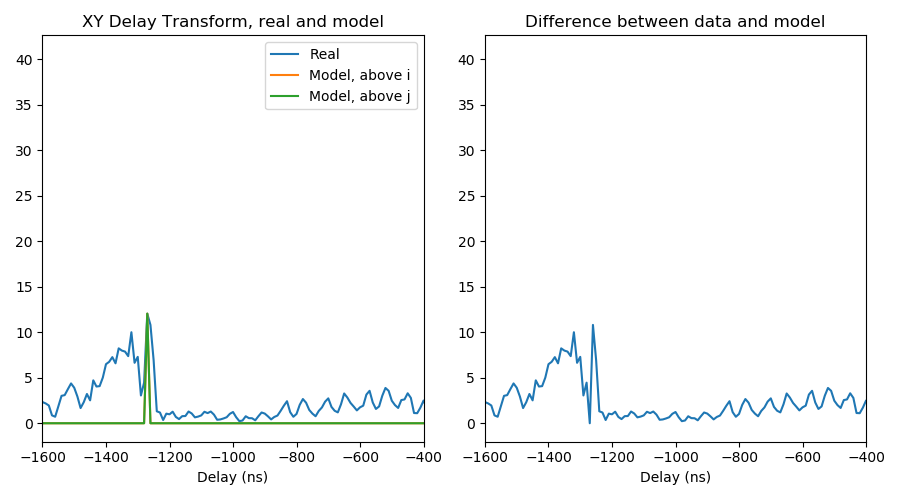

In [25]:
#Plot

real_below_maxi = np.max(np.abs(vis_avg_delay_real[(modeli_peak-4):(modeli_peak+4)]))
real_below_maxj = np.max(np.abs(vis_avg_delay_real[(modelj_peak-4):(modelj_peak+4)]))
#Calculate the correction factors
corr_factori = model_maxi / real_below_maxi
print 'Correction factor for ci:', corr_factori
corr_factorj = model_maxj / real_below_maxj
print  'Correction factor for cj:', corr_factorj

#Open the figures so that if one plot is zoomed, the other zooms as well
fig = plt.figure(figsize=(9,5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2, sharey = ax1, sharex = ax1)

plt.subplot(ax1)
plt.plot((delays_real),np.abs(vis_avg_delay_real), label='Real')
plt.plot((delays_real),np.abs(vis_avg_delay_ecib)/corr_factori, label='Model, above i')
plt.plot((delays_real),np.abs(vis_avg_delay_ecjb)/corr_factorj, label='Model, above j')
plt.xlabel('Delay (ns)')
plt.xlim(-1600,-400) # zoom-in
plt.legend()
plt.title('XY Delay Transform, real and model')

plt.subplot(ax2)
plt.plot(delays_real, np.abs(np.abs(vis_avg_delay_real)-(np.abs(vis_avg_delay_ecib)/corr_factori)))
plt.xlabel('Delay (ns)')
plt.title('Difference between data and model')

plt.tight_layout()

### Part 3: Other variables

Now that we have our exponential model (hopefully) printing the peak in the correct location, we can define the other variables from our equations. These are the autocorrelation data for both antenna and the amplitude factor in front. 

The amplitude factor is found by taking the amplitude matrix we created earlier and taking the mean across the antenna to find the average amplitude for each antennna. 

We also multiply the exponentials found eariler by the two autocorrelated data to create a term we will call V_cij. This term has the second amplitude correction factor dividing. 

In [26]:
#Create an array to hold the autocorrelation data
V_k = np.zeros((len(uv.antenna_numbers),uv.Nfreqs),dtype='complex')

# Step through each antenna and find autocorr data
for i,ant1 in enumerate(uv.ant_2_array):
    ant2 = uv.ant_1_array[i]
    if (ant1==ant2):
        x = uv.data_array[i,0,:,0]
        V_k[ant_dict[ant1]] = x
        
#Get autocorr variables
V_ii = V_k[ant_dict[antenna1]]
V_jj = V_k[ant_dict[antenna2]]

#Define the non-baseline dependent term
V_cij = ((V_ii * e_ci) + (V_jj * e_cj)) / 20

#Take the average across antennas to calculate the amplitude factor
Eps_ij = np.mean(out_bl_amp,axis=1)

#Finish building our model
out_bl_model = np.einsum('im,ij->mj',Eps_ij,V_cij)

#Take the delay transform
vis_out_bl_model = np.mean(np.fft.fftshift(np.fft.fft(out_bl_model,axis=1)),axis=0)

#Find the maximum value
model_max = np.max(np.abs(vis_out_bl_model))

Correction factor: 27.099976038219697


<IPython.core.display.Javascript object>


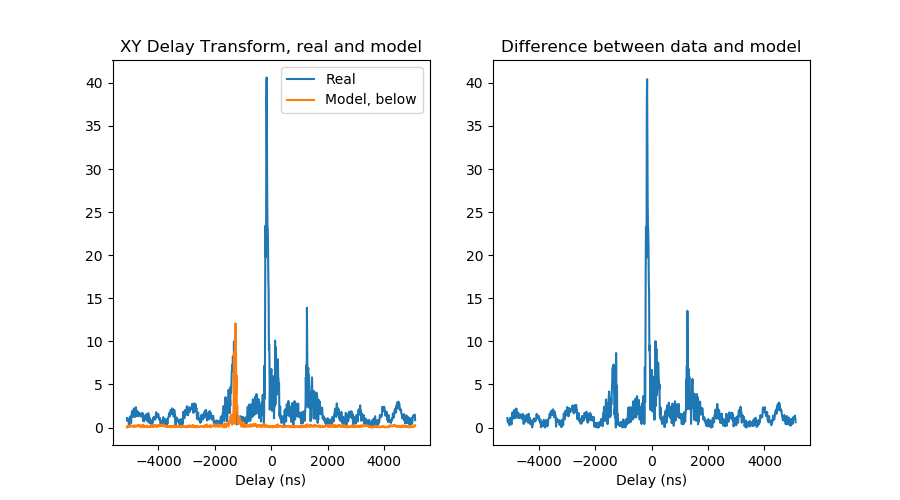

Text(0.5,1,'Difference between data and model')

In [28]:
#Plot
#Find the correction factor
corr_factor2 = model_max / real_below_maxi
print 'Correction factor:', corr_factor2

#Open the figures so that if one plot is zoomed, the other zooms as well
fig = plt.figure(figsize=(9,5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2, sharey = ax1, sharex = ax1)

plt.subplot(ax1)
plt.plot((delays_real),np.abs(vis_avg_delay_real), label='Real')
plt.plot((delays_real),np.abs(vis_out_bl_model)/corr_factor2, label='Model, below')
plt.xlabel('Delay (ns)')
#plt.xlim(-1600,-400) # zoom-in
plt.legend()
plt.title('XY Delay Transform, real and model')

plt.subplot(ax2)
plt.plot(delays_real, np.abs(np.abs(vis_avg_delay_real)-(np.abs(vis_out_bl_model)/corr_factor2)))
plt.xlabel('Delay (ns)')
plt.title('Difference between data and model')